<a href="https://colab.research.google.com/github/shukubota/colabs/blob/main/videoconvert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

def extract_frames(video_path, output_folder, max_frames=5):
    # Google Driveをマウント
    drive.mount('/content/drive')

    # ビデオファイルを開く
    video = cv2.VideoCapture(video_path)

    # 出力フォルダが存在しない場合は作成
    full_output_path = f"/content/drive/MyDrive/{output_folder}"
    if not os.path.exists(full_output_path):
        os.makedirs(full_output_path)

    # フレームカウンタ
    frame_count = 0

    frames = []

    while frame_count < max_frames:
        # フレームを読み込む
        success, frame = video.read()

        if not success:
            break

        # フレームを保存
        output_path = os.path.join(full_output_path, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(output_path, frame)

        # フレームを表示（Colab用）
        cv2_imshow(frame)

        frame_count += 1

        frames.append(frame)

    # ビデオファイルを閉じる
    video.release()

    print(f"合計 {frame_count} フレームを抽出しました。")
    print(f"フレームは {full_output_path} に保存されました。")

    return frames




In [4]:
import cv2
import numpy as np
import base64
from PIL import Image
import io
from google.colab.patches import cv2_imshow

def detect_and_inpaint_faces(frame):
    """
    フレームから顔を検出し、inpaintingを行う関数
    Args:
        frame: cv2で読み込んだ画像（numpy.ndarray）
    Returns:
        processed_image: 処理後の画像（numpy.ndarray）
        face_mask: 顔領域のマスク（numpy.ndarray）
    """
    # 顔検出器の読み込み
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # グレースケールに変換
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 顔検出
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # マスクの作成（顔領域を白、それ以外を黒に）
    face_mask = np.zeros(frame.shape[:2], dtype=np.uint8)

    # 検出された顔領域を少し大きめに取る
    for (x, y, w, h) in faces:
        # マスクを少し大きめに
        padding = int(min(w, h) * 0.1)  # パディングを10%に設定
        x1 = max(x - padding, 0)
        y1 = max(y - padding, 0)
        x2 = min(x + w + padding, frame.shape[1])
        y2 = min(y + h + padding, frame.shape[0])

        # マスクに顔領域を追加
        cv2.rectangle(face_mask, (int(x1), int(y1)), (int(x2), int(y2)), 255, -1)

    # インペインティングの実行
    processed_image = cv2.inpaint(frame, face_mask, 3, cv2.INPAINT_TELEA)

    return processed_image, face_mask

def prepare_for_imagen(image):
    """
    画像をImagen APIで使用できる形式に変換する関数
    Args:
        image: numpy.ndarray形式の画像
    Returns:
        base64_image: Base64エンコードされた画像文字列
    """
    # OpenCV画像をPIL形式に変換
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # PILイメージをバイトストリームに変換
    byte_stream = io.BytesIO()
    pil_image.save(byte_stream, format='PNG')
    byte_stream.seek(0)

    # Base64エンコード
    base64_image = base64.b64encode(byte_stream.getvalue()).decode('utf-8')

    return base64_image

def base64_to_cv2(base64_string):
    """
    Base64文字列をOpenCV画像形式に変換する関数
    """
    # Base64をデコード
    img_data = base64.b64decode(base64_string)

    # バイトデータをnumpy配列に変換
    nparr = np.frombuffer(img_data, np.uint8)

    # numpy配列をOpenCV画像に変換
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    return img

def process_frame_for_imagen(frame):
    """
    フレームを処理してImagen API用に準備する関数
    Args:
        frame: cv2で読み込んだ画像
    Returns:
        base64_processed: 処理済み画像のBase64文字列
        base64_mask: マスクのBase64文字列
    """
    # 顔検出とinpainting
    processed_image, face_mask = detect_and_inpaint_faces(frame)

    # Imagen API用にBase64エンコード
    base64_processed = prepare_for_imagen(processed_image)
    base64_mask = prepare_for_imagen(cv2.cvtColor(face_mask, cv2.COLOR_GRAY2BGR))

    return base64_processed, base64_mask

# 使用例
def main():
    # extract_framesで取得したフレームに対して処理を実行
    frame = cv2.imread("/content/drive/MyDrive/output_frames/frame_0000.jpg")

    if frame is None:
        print("画像の読み込みに失敗しました。パスを確認してください。")
        return

    # 処理の実行
    base64_processed, base64_mask = process_frame_for_imagen(frame)

    # 処理結果の確認
    processed_img = base64_to_cv2(base64_processed)
    mask_img = base64_to_cv2(base64_mask)

    # 結果の表示
    print("処理済み画像:")
    cv2_imshow(processed_img)
    print("\nマスク画像:")
    cv2_imshow(mask_img)

    return base64_processed, base64_mask

# extract_frames関数で使用する場合の例
def process_video_frame(frame):
    """
    ビデオフレームを処理する関数
    """
    base64_processed, base64_mask = process_frame_for_imagen(frame)

    # 結果の表示（必要に応じて）
    processed_img = base64_to_cv2(base64_processed)
    mask_img = base64_to_cv2(base64_mask)

    print("処理済み画像:")
    cv2_imshow(processed_img)
    print("\nマスク画像:")
    cv2_imshow(mask_img)

    return base64_processed, base64_mask

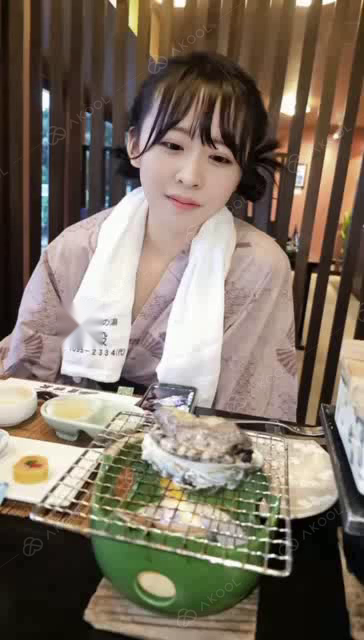

('iVBORw0KGgoAAAANSUhEUgAAAWwAAAKACAIAAAA3k9WKAAEAAElEQVR4nOz9aY9lSZIYipmZu5/lbhGRkZm1V/f0Y3M45IDCPJJ6kCAS/EDwgx5AUAChD/pp+vI+SYAAASIgfiA4DxIwgsAnzYw4GrKXafYy1VVdVblGxN3O4u5m74Od49fvEpGRWVlLz7ShEHXz3nP8+HE3t33Bf/J3PlwulzfbNSJGhBgjI1hLZ/O6qqqzqrLWlowiAgAAwMiIiCjGGGOjiMzmk8Vi8UcfvVsUhS1aRASxL168+KsfP/vlL3/53C7gAMQCwGw2K8tyMX9Q1/V0OiUiIkLE0PUxxm2zbNu298sYI2BARKQoIswAAIZK51xVTowxpihFREQQEQCYuWka7/1yuTx8LoBeg4iTyWSxWDjnYozee+dcCAER9Z8iwswh9ABAEAAAkPXt09/33/9wMplU5ezm5mY6ufxX/+pf/a//V/+MiKQuvPeliTHG/+v/6f/47/7dv2O/KYqCfOO9DyFYa/VNLy4uzs7O6J3NH/3RH/3+H/xeVVVA6xjjtrmOMT6Q0nv/4//yy7/4i7/om4m1FkIpIhatc84Yg4j6Ig/OL2azGTNPJpMHZ+eXl5fn7z+enZ/D2RSqCvrHq6dPf/5Xf/nJJ5+E9ZdN0yC3XddB5BjjNmCM0Sze+4f/8B/+t//dPz1//DiYHwIACgMAgQcA1BVoX3z22Wf/47//v3/yySfOtF3Xcdg2TTNDQkTvvff+4uLi3XffXSwWAHB1dQUAIhJjTBvEzJ9+uWzbdrPZhBDSjuhnEbHWish0Ov2n//SfIuLPfvaztlkd7yMA3NzcbLfbrusQses6Ziaioihms0lCBhH51//6X/+Df/AP/viP//gXv/jFyXHavmPmEEIIgZn1Xr1doSxLADDG/It/8S8++OCD//ef/AedtoJuJSIWRVGWZdd1L168ePbsWYyRiACgMQYACjex1qKtrLVnF48ePn

In [9]:
def process_frame_for_imagen(frame):
    """
    フレームを処理してImagen API用に準備する関数
    Args:
        frame: cv2で読み込んだ画像
    Returns:
        base64_processed: 処理済み画像のBase64文字列
        base64_mask: マスクのBase64文字列
    """
    # 顔検出とinpainting
    processed_image, face_mask = detect_and_inpaint_faces(frame)

    # Imagen API用にBase64エンコード
    base64_processed = prepare_for_imagen(processed_image)
    base64_mask = prepare_for_imagen(cv2.cvtColor(face_mask, cv2.COLOR_GRAY2BGR))

    return base64_processed, base64_mask

def main():
    video_path = "/content/drive/MyDrive/videoconvert/raw.mov"
    output_folder = "output_frames"
    max_frames = 1

    extract_frames(video_path, output_folder, max_frames)
    frames = extract_frames(video_path, output_folder, max_frames)
    frame = frames[0]

    base64_processed, base64_mask = process_frame_for_imagen(frame)

    # Decode the base64 strings into numpy arrays
    processed_img_np = np.frombuffer(base64.b64decode(base64_processed), np.uint8)
    mask_img_np = np.frombuffer(base64.b64decode(base64_mask), np.uint8)

    # Use cv2.imdecode to convert numpy arrays to OpenCV images
    processed_img = cv2.imdecode(processed_img_np, cv2.IMREAD_COLOR)
    mask_img = cv2.imdecode(mask_img_np, cv2.IMREAD_COLOR)

    # 処理結果の確認（必要に応じて）
    cv2_imshow(processed_img)
    # cv2_imshow(mask_img)

    return base64_processed, base64_mask

main()